#### Much of this code is adapted from Professor David Stewart's base code

In [ ]:
using LinearAlgebra
using Plots

## Optimal Fishing Effort

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u \\ \delta m + \beta f u \end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1$


#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [72]:
function F(t::Float64, x::Vector{Float64}, u::Float64, alpha::Float64, delta::Float64, beta::Float64, verbose=0)
    f, m = x
    dfdt = alpha * f * (1 - f) - beta * f * u
    dmdt = delta * m + beta * f * u

    func = [dfdt, dmdt]
    if verbose == 1
        println("================================")
        println("[F]: ",[dfdt, dmdt])
    end
    return func
end

function g(xv::Vector{Float64},verbose=0)
    if verbose == 1
        println("[g] g: ", -xv[2])
    end
    return -xv[2]
end

function dg(xv::Vector{Float64}, verbose=0) 
    if verbose == 1
        println("[dg] dg: ", [0.0, 1.0])
    end
    return [0.0, 1.0]
end

dg (generic function with 2 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{u}$
$\quad$ $\nabla_{u} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} -f \\ f \end{bmatrix}$

In [51]:
function dFdu(xvect::Vector{Float64},u::Float64,alpha::Float64,delta::Float64,beta::Float64,verbose=0)

    f, _ = xv
    
    grad = [-beta * f, beta * f]
    
    if verbose==1
        println("================================")
        println("[dFdu]: ", grad)
    end
    return grad
end

dFdu (generic function with 4 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{x}$
$\quad$ $\nabla_{x} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} \alpha -2 \alpha f - u  && 0  \\ u  && \delta \end{bmatrix}$

In [32]:
function dFdx(t::Float64, xv::Vector{Float64}, u::Float64, alpha::Float64, delta::Float64,beta::Float64, verbose=0)

    f, _ = xv
    
    jacobian = [    -alpha * (1 - 2*f) + beta * u     beta * f     ;  
                              beta * u                 delta      ]
    
    if verbose == 1
        println("================================")
        println("[dFdx]: ", jacobian)
    end
    return jacobian
end

dFdx (generic function with 4 methods)

#### Discretization via Euler's Method
$\quad$ $\textbf{x}_{k+1} = \textbf{x} + h\textbf{F}(\textbf{x}_{k},\textbf{u}_{k})$

This allows us to find $\textbf{x}(T)$ via a forward pass

In [84]:
function forwardstep(x0::Vector{Float64},t0::Float64,u::Vector{Float64},h::Float64,alpha::Float64,delta::Float64,beta::Float64,verbose=0)
    N = size(u,2) # number of cols of u
    n = length(x0)
    xs = zeros(eltype(x0),n,N+1)
    xs[:,1] = x0
    
    if verbose == 1
        println("================================")
        println("[forwardstep] N: ", size(u,2)) 
        println("[forwardstep] n: ", length(x0))
        println("[forwardstep] xs: ", zeros(eltype(x0),n,N+1))
        println("[forwardstep] xs[:,1]: ", x0)
    end
    for i = 0:N-1
        println(u[:,i+1])
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1],alpha,delta,beta)
    end
    xs
end

forwardstep (generic function with 9 methods)

#### Lagrange Multiplier Equations
$\quad$ $\lambda_{k-1} = \lambda_{k} + h\nabla_{x} \textbf{F}(\textbf{x}_k, \textbf{u}_k)^T \lambda$

Moving backwards from the last $\lambda$ fills in the rest of the $\lambda$'s via a backward pass

In [62]:
# filling in the lagrange multipliers 
function adjointstep(λend::Vector{Float64},t0::Float64,dFdx::Function,xs::Vector{Float64},u::Float64;
        h::Float64,alpha::Float64,delta::Float64,beta::Float64,verbose=0)
    N = size(u,1) - 1
    n = length(λend)
    λs = zeros(eltype(λend),n,size(xs, 2))
    λs[:,N] = λend
    if verbose == 1
        println("================================")
        println("[adjointstep] N: ", size(u,2))
        println("[adjointstep] m: ", length(λend))
        println("[adjointstep] λs: ", zeros(eltype(λend),n,N))
        println("[adjointstep] λs[:,N]: ",λend)
    end
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xs[:,i+1],u[:,i+1],alpha,delta,beta)*λs[:,i+2]
    end
    λs
end


adjointstep (generic function with 2 methods)

#### Objective function
$\quad$ $g(\textbf{x}_N)=G(\textbf{u}_{0}, \textbf{u}_{1}, ... , \textbf{u}_{N-1})$

where $g(\textbf{x}_k)$ is the output at each step $k$

In [6]:
function G(x0::Vector{Float64},t0::Float64,u::Vector{Float64},h::Float64,F::Function,g::Function, alpha::Float64;
        delta::Float64,beta::Float64,verbose=0)
    xs = forwardstep(x0,t0,F,u,h,alpha,delta,beta)
    if verbose == 1
        println("================================")
        println("[G] g(xs[:,end]: ", g(xs[:, end]))
    end
    g(xs[end,2])
end

G (generic function with 1 method)

#### Gradient of objective function with respect to $\textbf{u}$
$\quad$ $\nabla_{u_{k}} g(\textbf{x}_{N}) = \nabla_{u}\textbf{F}(\textbf{x}_{k}, \textbf{u}_{k})^T \lambda_{k}$

In [7]:
function dG(x0::Vector{Float64},t0::Float64,u::Vector{Float64},h::Float64,F::Function,dFdx::Function,dFdu::Function;
        dg::Function,alpha::Float64,delta::Float64,beta::Float64,verbose=0)
    xs = forwardstep(x0,t0,F,u,h,alpha,delta)
    λend = dg(xs[:,end])
    λs = adjointstep(λend,t0,dFdx,xs,u,h,alpha,delta)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    if verbose == 1
        println("================================")
        println("[dG] xs: ", forwardstep(x0,t0,F,u,h,alpha,delta,beta))
        println("[dG] λend: ", dg(xs[:,end]))
        println("[dG] λs: ", adjointstep(λend,t0,dFdx,xs,u,h,alpha,delta,beta))
        println("[dG] dGval: ", zeros(eltype(u),size(u,1),size(u,2)))
    end
    for i = 0:size(u,2)-1
        dGval[:,i+1] = h*dFdu(t0+i*h,xs[:,i+1],u[:,i+1],alpha,delta)'*λs[:,i+1]
    end
    dGval
end

dG (generic function with 1 method)

#### Projection of controls onto $\space \mathcal{U}$
$\quad$ Search direction: $\textbf{d}=[(\textbf{d}_{0})^T, (\textbf{d}_{2})^T, ... , (\textbf{d}_{N-1})^T]^T$\
$\quad$ New control: $\textbf{u}^{+}(\alpha) = Proj_{\mathcal{U}}(\textbf{u}+\alpha \textbf{d})$, $\space$ $\mathcal{U}$ convex

This is to incorporate the constraints $\textbf{u}_{k} \in U \space \forall k$

In [30]:
function proj_u(u::Vector{Float64},a::Float64,b::Float64,verbose=0)
    proj = [max(a,min(b,uval)) for uval in u]
    if verbose == 1
        println("================================")
        println("[proj_u] u: ", u)
        println("[proj_u] a: ", a)
        println("[proj_u] b: ", b)
        println("[proj_u]: ", proj)
    end
    return proj
end

proj_u (generic function with 4 methods)

#### Gradient Descent
$\quad$ $\textbf{u}_{k+1} = \textbf{u}_{k} - s\nabla_{u}g(\textbf{x}_{k})$\
$\quad$ $\space\space\space\space\space\space\space\space = \textbf{u}_{k} -s\nabla_{u}\textbf{F}(\textbf{x}_{k}, \textbf{u}_{k})^T \lambda_{k}$

In [32]:
function grad_descent(u::Vector{Float64}, s::Float64, grad_val::Vector{Float64})
    return u-(s*grad_val)
end

grad_descent (generic function with 1 method)

#### Backtracking Line Search
Sufficient Decrease Condition: 

$\quad$ $G(\textbf{u}^{+}(\alpha))\leq G(\textbf{u}) + c_{1}\nabla G(\textbf{u})^T (\textbf{u}^{+}(\alpha)-\textbf{u})$

While this condition is satisfied, we will continue dividing our step length $s$ by $2$. We will break out of the loop if $s$ becomes too small.

In [33]:
function backtracking_line_search(x0::Vector{Float64},t0::Float64,h::Float64,F::Function,g::Function,Gval::Vector{Float64};
        dGval::Vector{Float64},s0::Float64,c1::Float64, proj::Function,G::Function,alpha::Float64,delta::Float64)
    Gvalold = Gval
    s = s0
    unew = proj(u-s*dGval) 
    Gval = G(x0,t0,unew,h,F,g,alpha,delta)
    iterations = 0
    while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-12*s0
        s = s / 2
        unew = proj(u-s*dGval)
        Gval = G(x0,t0,unew,h,F,g,alpha,delta)
        iterations += 1
    end
    println("Backtracking iterations: ", iterations)
    return s, unew
end

backtracking_line_search (generic function with 1 method)

#### Optimal Control Algorithm
Performs gradient descent in conjunction with backtracking line search on the iterates of $\textbf{u}$

In [13]:
function optcontrol(x0::Vector{Float64},t0::Float64,u::Vector{Float64},h::Float64,alpha::Float64,delta::Float64;
        F::Function,dFdx::Function,dFdu::Function,g::Function, dg::Function,proj::Function, eps=1e-2,s0=1.0, c1=0.05,maxiter::Int=10_000,ulist=nothing,trace=0)
    Gval = G(x0,t0,u,h,F,g,alpha,delta,beta,1)
    Gvalold = Gval
    if trace > 0
        println("optcontrol: Gval = $Gval")
    end
    dGval = dG(x0,t0,u,h,F,dFdx,dFdu,dg,alpha,delta,beta,1)
    if trace > 1
        println("optcontrol: dGval = ",dGval)
    end
    firsttime = true
    iter = 0
    if ulist != nothing
        push!(ulist,u)
    end
    if trace > 0
        println("optcontrol: iteration $iter: Gval = $Gval")
        println("optcontrol: u = ",u)
    end
    while ( firsttime || (Gvalold - Gval > eps) ) && (iter < maxiter)
        Gvalold = Gval
        s = s0
        unew = proj(u-s*dGval) # projected gradient descent
        Gval = G(x0,t0,unew,h,F,g,alpha,delta,beta1)
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-12*s0
            s = s / 2
            unew = proj(u-s*dGval)
            Gval = G(x0,t0,unew,h,F,g,alpha,delta,beta,1)
        end
        if trace > 0
            println()
            println("optcontrol: s = $s")
            println("optcontrol: Gval = $Gval, Gval-Gvalold = $(Gval-Gvalold)")
            if trace > 1
                println("optcontrol: unew = ",unew)
                println("optcontrol: dGval = ",dGval)
            end
        end
        u = unew
        firsttime = false
        dGval = dG(x0,t0,u,h,F,dFdx,dFdu,dg,alpha,delta,beta,1)
        left = norm(proj(u + alpha * dGval) - u)/min(alpha * norm(dGval),1)
        if norm(left < eps)
            break
        end
        if trace > 1
            println("optcontrol: dGval = ",dGval)
        end
        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
    end
    (u,iter)
end

optcontrol (generic function with 2 methods)

#### Verifying that our gradients are correct

In [52]:
using LinearAlgebra
xv  = [2.1; 1.1]
dxv = 1e-3*[1.2; -0.7]
t = 0.0; u = [0.5]; du = 1e-3*[0.7]
T = 20 # Start with half the maximum effort
alpha = 0.5
delta = 0.5
beta = 0.5
@show (F(t,xv+dxv,u[1],alpha,delta,beta)-F(t,xv-dxv,u[1],alpha,delta,beta)-2dFdx(t,xv,u[1],alpha,delta,beta)*dxv)/norm(dxv)
@show (F(t,xv,u[1]+du[1],alpha,delta,beta)-F(t,xv,u[1]-du[1],alpha,delta,beta)-2*dFdu(xv,u[1],alpha,delta,beta)*du[1])/norm(du)
@show (g(xv+dxv,1)-g(xv-dxv,1)-2*dot(dg(xv),dxv))/norm(dxv)

((F(t, xv + dxv, u[1], alpha, delta, beta) - F(t, xv - dxv, u[1], alpha, delta, beta)) - (2 * dFdx(t, xv, u[1], alpha, delta, beta)) * dxv) / norm(dxv) = [-5.333834713047667, 7.960343167660394e-15]
((F(t, xv, u[1] + du[1], alpha, delta, beta) - F(t, xv, u[1] - du[1], alpha, delta, beta)) - 2 * dFdu(xv, u[1], alpha, delta, beta) * du[1]) / norm(du) = [1.9949319973733282e-13, 1.1771337872699762e-13]
[g] g: -1.0993000000000002
[g] g: -1.1007
((g(xv + dxv, 1) - g(xv - dxv, 1)) - 2 * dot(dg(xv), dxv)) / norm(dxv) = 2.015484102096234


2.015484102096234

In [85]:
# function forwardstep(x0::Vector{Float64},t0::Float64,F::Function,u::Vector{Float64},h::Float64,alpha::Float64;
#         delta::Float64,beta::Float64,verbose=0)
println(typeof(xv0))
println(typeof(t))
println(typeof(F))
println(typeof(u[1]))
h = 0.1
xs = forwardstep(xv0,t,vec(u),h,alpha,delta,beta,1)

Vector{Float64}
Float64
typeof(F)
Float64
[forwardstep] N: 1
[forwardstep] n: 2
[forwardstep] xs: [0.0 0.0; 0.0 0.0]
[forwardstep] xs[:,1]: [1.0, 0.0]
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


LoadError: MethodError: no method matching -(::Float64, ::Vector{Float64})
For element-wise subtraction, use broadcasting with dot syntax: scalar .- array

[0mClosest candidates are:
[0m  -(::Real, [91m::Complex{Bool}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mcomplex.jl:321[24m[39m
[0m  -(::Real, [91m::Complex[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mcomplex.jl:333[24m[39m
[0m  -(::Number, [91m::UniformScaling[39m)
[0m[90m   @[39m [36mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4muniformscaling.jl:147[24m[39m
[0m  ...


In [78]:
λend = dg(xs[:,end])

2-element Vector{Float64}:
  0.0
 -1.0

In [79]:
λs = adjointstep(λend,0.0,dFdx,xs,u,h,alpha,delta)

2×20 Matrix{Float64}:
  0.0       0.0       0.0      …   0.0      0.0     0.0    0.0   0.0
 -6.11591  -5.55992  -5.05447     -1.4641  -1.331  -1.21  -1.1  -1.0

In [80]:
dFdx(0,xs[:,end-1],u[:,end],alpha,delta)'*λend

2-element Vector{Float64}:
  0.0
 -1.0

In [81]:
G(xv0,0.0,u,h,F,g,alpha,delta)

8.531471623413532

In [82]:
dG(xv0,0.0,u,h,F,dFdx,dFdu,dg,alpha,delta)

1×20 Matrix{Float64}:
 -0.611591  -0.611591  -0.606031  …  -0.235765  -0.215436  -0.196664

In [83]:
du = 1e-3*rand(1,20)
(G(xv0,0.0,u+du,h,F,g,alpha,delta)-G(xv0,0.0,u-du,h,F,g,alpha,delta)-2*dot(dG(xv0,0.0,u,h,F,dFdx,dFdu,dg,alpha,delta),du))/norm(h*du,1)

-3.350423641866694

#### Initial Parameters #1:
$\quad$ $T = 20\space years, \alpha = 0.1/year, \delta = 0.05/year, u_{max}=0.5, N=200, h=0.1$

In [14]:
using LinearAlgebra
xv  = [2.1; 1.1]
dxv = 1e-3*[1.2; -0.7]
t = 0; u = [0.5]; du = 1e-3*[0.7]
alpha = 0.5
delta = 0.5

@show (F(t,xv+dxv,u,alpha,delta)-F(t,xv-dxv,u,alpha,delta)-2dFdx(t,xv,u,alpha,delta)*dxv)/norm(dxv)
@show (F(t,xv,u+du,alpha,delta,1)-F(t,xv,u-du,alpha,delta,1)-2*dFdu(t,xv,u,alpha,delta,1)*du)/norm(du)
# @show (g(xv+dxv)-g(xv-dxv)-2*dot(dg(xv),dxv))/norm(dxv)

((F(t, xv + dxv, u, alpha, delta) - F(t, xv - dxv, u, alpha, delta)) - (2 * dFdx(t, xv, u, alpha, delta)) * dxv) / norm(dxv) = [0.5038710255246133, 0.8637789008982342]
[F] f: -2.2064700000000004
[F] m: -2.2064700000000004
[F] dfdf: -2.2064700000000004
[F] dmdt: -2.2064700000000004
[F] f: -2.2035300000000007
[F] m: -2.2035300000000007
[F] dfdf: -2.2035300000000007
[F] dmdt: -2.2035300000000007
[dFdu]: [-2.1; 2.1;;]
((F(t, xv, u + du, alpha, delta, 1) - F(t, xv, u - du, alpha, delta, 1)) - 2 * dFdu(t, xv, u, alpha, delta, 1) * du) / norm(du) = [3.9898639947466563e-13, -8.17798210103352e-14]


2-element Vector{Float64}:
  3.9898639947466563e-13
 -8.17798210103352e-14

In [138]:
N = 20
h = 0.1
u = -ones(1,N)
xv0 = [1.0; 0.0]
#function forwardstep(x0,t0,F::Function,u,h,alpha,delta, verbose=0)

xs = forwardstep(xv0,t,F,u,h,alpha,delta,1)

[forwardstep] N: 20
[forwardstep] n: 2
[forwardstep] xs: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[forwardstep] xs[:,1]: [1.0, 0.0]


2×21 Matrix{Float64}:
 1.0   1.1   1.2045   1.31263   1.42338   …   2.6626    2.70752   2.74711
 0.0  -0.1  -0.215   -0.3462   -0.494773     -4.91504  -5.42705  -5.96916

In [139]:
λend = dg(xs[:,end])

2-element Vector{Float64}:
  0.0
 -1.0

In [84]:
λs = adjointstep(λend,0.0,dFdx,xs,u,h,alpha,delta,1)

[adjointstep] N: 20
[adjointstep] m: 2
[adjointstep] λs: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[adjointstep] λs[:,N]: [0.0, 1.0]


2×20 Matrix{Float64}:
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0     0.0   0.0
 2.52695  2.40662  2.29202  2.18287     1.21551  1.15763  1.1025  1.05  1.0

In [85]:
dFdx(0,xs[:,end-1],u[:,end],alpha,delta,1)'*λend

dFdx: [-1.2075172909916656 -1.0; 0.0 0.5]


2-element Vector{Float64}:
 0.0
 0.5

In [86]:
G(xv0,0.0,u,h,F,g,alpha,delta,1)

[G] g(xs[:,end]: 5.969155071721966


5.969155071721966

In [87]:
dG(xv0,0.0,u,h,F,dFdx,dFdu,dg,alpha,delta,1)

[dG] xs: [1.0 1.1 1.2045000000000001 1.3126339875000002 1.4233786863679927 1.535585145082858 1.6480218299553295 1.7594263068481633 1.8685612064139194 1.9742693382702552 2.07552276800909 2.1714614451842476 2.2614184215658018 2.3449305209308138 2.421735141670793 2.491755358101249 2.555076423585122 2.6119171106048635 2.66259912756207 2.7075172909916656 2.747112390589473; 0.0 -0.1 -0.21500000000000002 -0.34620000000000006 -0.4947733987500001 -0.6618499373242994 -0.8485009486988002 -1.0557281791292732 -1.2844572187705532 -1.535536200350473 -1.8097399441950222 -2.1077792182056823 -2.4303143236343914 -2.7779718819726913 -3.1513635281644072 -3.551105218739707 -3.977836015486817 -4.432235458619671 -4.91503894261114 -5.427050802497904 -5.969155071721966]
[dG] λend: [0.0, 1.0]
[dG] λs: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 2.5269501953756395 2.406619233691085 2.2920183178010336 2.182874588381937 2.0789281794113683 1.9799315994393982 1.8856491423232364 1

1×20 Matrix{Float64}:
 0.252695  0.264728  0.276074  0.286532  …  0.287964  0.279573  0.270752

In [88]:
N = 80
h = 0.025
u = -ones(1,N)
xv0 = [1.0; 0.0]

2-element Vector{Float64}:
 1.0
 0.0

In [97]:
ulist = []
u = zeros(1,20)
h = 0.1
uopt,iterns = optcontrol(xv0,0.0,u,h,F,dFdx,dFdu,g,dg,u->proj_u(u,-1.0,1.0),eps=1e-4,maxiter=40,ulist=ulist,trace=2, alpha=alpha, delta=delta)

optcontrol: Gval = -0.0
[0.10993985842654036]
[0.10939289395675658]
[0.10884865070324037]
[0.10830711512760237]
[0.10776827375880832]
[0.10723211319284409]
[0.10669862009238218]
[0.10616778118644994]
[0.10563958327009944]
[0.10511401320407905]
[0.10459105791450651]
[0.1040707043925438]
[0.10355293969407345]
[0.10303775093937656]
[0.10252512531281249]
[0.10201505006249999]
[0.1015075125]
[0.1010025]
[0.10049999999999999]
[0.1]
optcontrol: dGval = [0.10993985842654036 0.10939289395675658 0.10884865070324037 0.10830711512760237 0.10776827375880832 0.10723211319284409 0.10669862009238218 0.10616778118644994 0.10563958327009944 0.10511401320407905 0.10459105791450651 0.1040707043925438 0.10355293969407345 0.10303775093937656 0.10252512531281249 0.10201505006249999 0.1015075125 0.1010025 0.10049999999999999 0.1]
optcontrol: iteration 0: Gval = -0.0
optcontrol: u = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]

optcontrol: s = 9.094947017729282e-13
optcontr

([-9.998971875260428e-14 -9.949225746527789e-14 … -9.140421752817928e-14 -9.094947017729283e-14], 1)

In [96]:
N = 200
h = 0.1
u = -ones(1,N)
xv0 = [1.0; 1.0]

du = 1e-3*rand(1,N)
@show(G(xv0,0.0,u+du,h,F,g,alpha,delta)-G(xv0,0.0,u-du,h,F,g,alpha,delta)-2*dot(dG(xv0,0.0,u,h,F,dFdx,dFdu,dg,alpha,delta),du))/norm(h*du,1)

ulist = []
u = zeros(1,20)
h = 0.1
uopt,iterss = optcontrol(xv0,0.0,u,h,alpha,delta,F,dFdx,dFdu,g,dg,u->proj_u(u,-1.0,1.0),eps=1e-4,maxiter=40,ulist=ulist,trace=0)

(G(xv0, 0.0, u + du, h, F, g, alpha, delta) - G(xv0, 0.0, u - du, h, F, g, alpha, delta)) - 2 * dot(dG(xv0, 0.0, u, h, F, dFdx, dFdu, dg, alpha, delta), du) = -118828.32538354245
[G] g(xs[:,end]: -6.727499949325601
[dG] xs: [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.1 1.2100000000000002 1.3310000000000002 1.4641000000000002 1.61051 1.7715610000000002 1.9487171 2.1435888100000002 2.357947691 2.5937424601 2.8531167061100002 3.1384283767210004 3.4522712143931003 3.7974983358324104 4.177248169415652 4.594972986357217 5.054470284992938 5.559917313492232 6.115909044841455 6.727499949325601]
[dG] λend: [0.0, -1.0]
[dG] λs: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -6.115909044841455 -5.559917313492232 -5.054470284992938 -4.594972986357217 -4.177248169415652 -3.7974983358324104 -3.4522712143931003 -3.1384283767210004 -2.8531167061100002 -2.5937424601 -2.357947691 -2.1435888100000002 -1.9487171 -1.771561000

([1.0 1.0 … 1.0 1.0], 24)

In [97]:
uopt

1×20 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [98]:
xsopt = forwardstep(xv0,0.0,F,uopt,h,alpha,delta)

2×21 Matrix{Float64}:
 1.0  0.9  0.819  0.751924  0.695385  …  0.34359  0.331784   0.320776
 1.0  1.2  1.41   1.6329    1.87138      8.58809  9.48126   10.4626

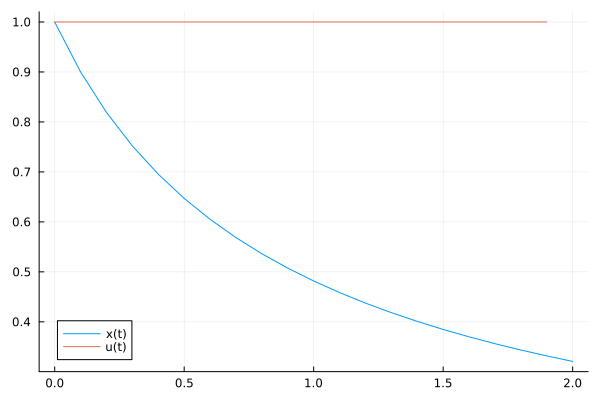

In [99]:
using Plots
plot(h*(0:20),xsopt[1,:],label="x(t)")
plot!(h*(0:19),uopt[1,:],label="u(t)")

## Optimal Fishing Effort - Addition of Predator

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u - \gamma f s\\ \gamma f s - \rho s \\ \delta m + \beta f u\end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1, \rho = 1, \alpha = 0.1, \gamma = 5$
#### So,
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(1-f)-f u \\ \delta m + f u \end{bmatrix}, x(0)=x_{0}, \textbf{u}(t)\in U  \space \forall t$

#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ -1 \end{bmatrix}$

In [104]:
function F_pred(t, x, u, alpha, delta, verbose=0)
    f, s, m = x
    dfdt = alpha * f * (1 - f) - f* u[1] - 5 * f * s
    dsdt = 5 * f * s - s
    dmdt = delta * m + u[1] * f

    if verbose == 1
        println("================================")
        println("[F] f: ", dfdt)
        println("[F] m: ", dfdt)
        println("[F] dfdf: ", dfdt)
        println("[F] dmdt: ", dfdt)
    end

    return [dfdt, dmdt]
end

function g(xv,verbose=0)
    if verbose == 1
        println("[g] g: ", -xv[2])
    end
    return -xv[2]
end

function dg(xv, verbose=0) 
    if verbose == 1
        println("[dg] dg: ", [0.0, 0.0, -1.0])
    end
    return [0.0, -1.0]
end

function dFdu_pred(t, xvect,u,alpha,delta,verbose=0)
    if verbose==1
        println("================================")
        println("[dFdu]: ",reshape([-xvect[1] ; xvect[1]],2,1))
    end
    return reshape([-xvect[1] ; xvect[1]],2,1)
end

function dFdx_pred(t, xv, u, alpha, delta,verbose=0)
    if verbose == 1
        println("================================")
        println("dFdx: ", [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta])
    end
    return [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta]
end

dFdu_pred (generic function with 2 methods)

In [105]:
using LinearAlgebra
xv  = [2.1; 1.1; 1.2]
dxv = 1e-3*[1.2; -0.7; 0.5]
t = 0; u = [0.5]; du = 1e-3*[0.7]
T = 20
alpha = 1
delta = 1
@show (F_pred(t,xv+dxv,u,alpha,delta)-F_pred(t,xv-dxv,u,alpha,delta)-2dFdx_pred(t,xv,u,alpha,delta)*dxv)/norm(dxv)
@show (F_pred(t,xv,u+du,alpha,delta,1)-F_pred(t,xv,u-du,alpha,delta,1)-2*dFdu_pred(t,xv,u,alpha,delta,1)*du)/norm(du)
@show (g_pred(xv+dxv,1)-g_pred|(xv-dxv,1)-2*dot(dg_pred(xv),dxv))/norm(dxv)

LoadError: UndefVarError: `dFdx_pred` not defined